In [1]:
from functools import reduce
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Construct 3D rotation matrix when rotations around x,y,z axes are specified 
def construct_RotationMatrixHomogenous(rotation_angles):
    assert(type(rotation_angles)==list and len(rotation_angles)==3)
    RH = np.eye(4,4)
    cv2.Rodrigues(np.array(rotation_angles), RH[0:3, 0:3])
    return RH

In [4]:
# https://en.wikipedia.org/wiki/Rotation_matrix
def getRotationMatrixManual(rotation_angles):
    
    rotation_angles = list(map(lambda x : np.deg2rad(x), rotation_angles))
    
    phi         = rotation_angles[0] # around x
    gamma       = rotation_angles[1] # around y
    theta       = rotation_angles[2] # around z
    
    # X rotation
    Rphi        = np.eye(4,4)
    sp          = np.sin(phi)
    cp          = np.cos(phi)
    Rphi[1,1]   = cp
    Rphi[2,2]   = Rphi[1,1]
    Rphi[1,2]   = -sp
    Rphi[2,1]   = sp
    
    # Y rotation
    Rgamma        = np.eye(4,4)
    sg            = np.sin(gamma)
    cg            = np.cos(gamma)
    Rgamma[0,0]   = cg
    Rgamma[2,2]   = Rgamma[0,0]
    Rgamma[0,2]   = sg
    Rgamma[2,0]   = -sg
    
    # Z rotation (in-image-plane)
    Rtheta      = np.eye(4,4)
    st          = np.sin(theta)
    ct          = np.cos(theta)
    Rtheta[0,0] = ct
    Rtheta[1,1] = Rtheta[0,0]
    Rtheta[0,1] = -st
    Rtheta[1,0] = st
    
    R           = reduce(lambda x,y : np.matmul(x,y), [Rphi, Rgamma, Rtheta]) 
    
    return R

In [5]:
def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

In [6]:
def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = getRotationMatrixManual([phi, gamma, theta])
    
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 
    
    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
    ptsIn = np.array([[
                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength

In [24]:
def warpImage(src,theta, phi,gamma,scale,fovy,corners=None):
    H,W,Nc    = src.shape
    M,sl      = warpMatrix(W,H, theta,phi,gamma, scale,fovy);          #Compute warp matrix
    sl = int(sl)
    print('Output image dimension = {}'.format(sl))
    dst = cv2.warpPerspective(src,M, (sl,sl));                  #Do actual image warp
    return dst,M

In [33]:
def transform_pnts( pnts, M33):
    """
    :param pnts: 2D pnts, left-top, right-top, right-bottom, left-bottom
    :param M33: output from transform_image()
    :return: 2D pnts apply perspective transform
    """
    pnts = np.asarray(pnts, dtype=np.float32)
    pnts = np.array([pnts])
    dst_pnts = cv2.perspectiveTransform(pnts, M33)[0]

    return dst_pnts

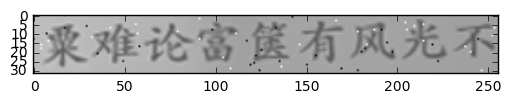

In [34]:
src    = cv2.imread('C:\jianweidata\ocrdataset2\chn/00000009.jpg')
src    = src[...,::-1] # BGR to RGB
H,W,Nc = src.shape
plt.imshow(src)

pt = [[0,0],[0,255],[32,0],[32,255]]

Output image dimension = 284


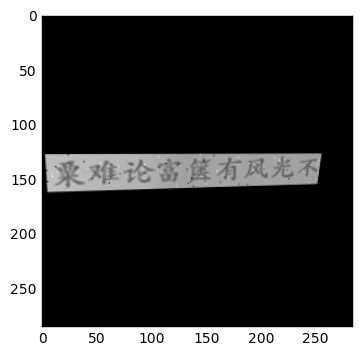

In [39]:
imgwarped,M = warpImage(src,3,-15, 15, 1, 50)
newpt = transform_pnts(pt,M)
plt.imshow(imgwarped)

In [15]:
newpt = cv2.rectangle

53.13010235415598